In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


from sklearn.pipeline import Pipeline
# sklearn.pipeline.Pipeline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
olist_customers_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
olist_orders_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
olist_order_items_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
olist_geolocation_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
olist_products_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
product_category_name_translation=  pd.read_csv('./kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
olist_geolocation_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
olist_sellers_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
olist_order_payments_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
product_data = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
eng_cat = pd.read_csv('./kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
olist_order_payments_dataset = pd.read_csv('./kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
filter1 = olist_orders_dataset['order_purchase_timestamp'] > '2016-12-31'
filter2 = olist_orders_dataset['order_purchase_timestamp'] < '2018-09-1'
filter3 = ~olist_orders_dataset['order_status'].isin(['unavailable' ,'canceled']) ## not in condition
olist_orders_dataset = olist_orders_dataset[(filter1 & filter2 & filter3)] ### order between 2017 and 2018 and ordered.
print('numbers of orders : ', olist_orders_dataset.shape[0])
print('first order : '  , olist_orders_dataset['order_purchase_timestamp'].min())
print('last order : ' , olist_orders_dataset['order_purchase_timestamp'].max())

numbers of orders :  97910
first order :  2017-01-05 11:56:06
last order :  2018-08-29 15:00:37


In [3]:
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97910 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97910 non-null  object        
 1   customer_id                    97910 non-null  object        
 2   order_status                   97910 non-null  object        
 3   order_purchase_timestamp       97910 non-null  datetime64[ns]
 4   order_approved_at              97891 non-null  object        
 5   order_delivered_carrier_date   97306 non-null  object        
 6   order_delivered_customer_date  96203 non-null  object        
 7   order_estimated_delivery_date  97910 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.7+ MB


In [7]:
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [8]:
olist_customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### order with customer data

In [39]:
customer_data = pd.merge(olist_orders_dataset, olist_customers_dataset, on = 'customer_id', how = 'inner' )
zip_location =  olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean' , 'geolocation_lng':'mean'}).reset_index().rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix'})
customer_data = pd.merge(  customer_data , zip_location , on='customer_zip_code_prefix', how='inner' ).rename(columns={ 'geolocation_lat':'geolocation_lat_customer' ,'geolocation_lng':'geolocation_lng_customer'}) ## zip location
customer_data = pd.merge(  customer_data,olist_order_items_dataset,on='order_id' , how='inner' ) ## item info
customer_data = pd.merge(  customer_data,olist_sellers_dataset,on='seller_id' , how='inner'  ) ## seller info
customer_data = pd.merge(  customer_data,zip_location.rename(columns={'customer_zip_code_prefix' : 'seller_zip_code_prefix'}),on='seller_zip_code_prefix' , how='inner'  ).rename(columns={ 'geolocation_lat':'geolocation_lat_seller' ,'geolocation_lng':'geolocation_lng_seller'}) ## zip location
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111204 entries, 0 to 111203
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111204 non-null  object        
 1   customer_id                    111204 non-null  object        
 2   order_status                   111204 non-null  object        
 3   order_purchase_timestamp       111204 non-null  datetime64[ns]
 4   order_approved_at              111189 non-null  object        
 5   order_delivered_carrier_date   110509 non-null  object        
 6   order_delivered_customer_date  109336 non-null  object        
 7   order_estimated_delivery_date  111204 non-null  object        
 8   customer_unique_id             111204 non-null  object        
 9   customer_zip_code_prefix       111204 non-null  int64         
 10  customer_city                  111204 non-null  object        
 11  

In [10]:
customer_data = customer_data[['order_id' ,  'customer_id'  ,'geolocation_lat_customer' ,'geolocation_lng_customer' , 'customer_unique_id' , 'geolocation_lat_seller' , 'geolocation_lng_seller' , 'price' ,'freight_value' ]]

In [11]:
from math import radians, sin, cos, sqrt, atan2

# def haversine_distance(lat1, lon1, lat2, lon2):
def haversine_distance(row):

    lat1 = radians(row['geolocation_lat_customer'])
    lon1 = radians(row['geolocation_lng_customer'])
    lat2 = radians(row['geolocation_lat_seller'])
    lon2 = radians(row['geolocation_lng_seller'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers
    return distance

customer_data['distance'] = customer_data.apply(haversine_distance, axis=1)

In [12]:
customer_data['customer_unique_id'].value_counts()

customer_unique_id
c8460e4251689ba205045f3ea17884a1    24
4546caea018ad8c692964e3382debd19    21
698e1cf81d01a3d389d96145f7fa6df8    20
c402f431464c72e27330a67f7b94d4fb    20
0f5ac8d5c31de21d2f25e24be15bbffb    18
                                    ..
bc1c7b16bdfd21e256990040dd1fd11d     1
3b25730ea4e83eae8c0e90b100dde51d     1
3c38d8ff25f661253b873a6ce2eccee4     1
675ad24fac09e3c1edfbc4c0e9e7592b     1
60350aa974b26ff12caad89e55993bd6     1
Name: count, Length: 94239, dtype: int64

In [13]:
customer_data [ customer_data['customer_unique_id'] ==  '4546caea018ad8c692964e3382debd19' ]

,order_id,customer_id,geolocation_lat_customer,geolocation_lng_customer,customer_unique_id,geolocation_lat_seller,geolocation_lng_seller,price,freight_value,distance
99227,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99228,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99229,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99230,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99231,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99232,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99233,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99234,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99235,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436
99236,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,-23.680743,-46.784224,4546caea018ad8c692964e3382debd19,-23.488234,-46.469989,1.2,7.89,38.518436


In [14]:
result = customer_data.groupby('customer_unique_id').agg({
    'order_id': 'nunique',  # Count of unique order_id for each customer means number
    'customer_id': 'count',  # number of products orderd
    'price':'mean',
    'geolocation_lat_customer': 'mean',  # Mean latitude
    'geolocation_lng_customer': 'mean' , # Mean longitude
    'distance' : 'mean',
}).reset_index()  # Reset index to make 'customer_unique_id' a column again


# Renaming the columns for clarity
result.columns = ['customer_unique_id', '#orders', '#products','mean_price', 'mean_lat', 'mean_lng' , 'mean_distance_from_seller']

result

,customer_unique_id,#orders,#products,mean_price,mean_lat,mean_lng,mean_distance_from_seller
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,-23.340235,-46.830140,110.568636
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,-23.559115,-46.787626,22.168333
2,0000f46a3911fa3c0805444483337064,1,1,69.00,-27.542880,-48.633426,516.938836
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,-1.312214,-48.483159,2481.287188
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,-23.505548,-47.469705,154.507887
...,...,...,...,...,...,...,...
94234,fffcf5a5ff07b0908bd4e2dbc735a684,1,2,785.00,-8.362511,-36.562343,1996.470471
94235,fffea47cd6d3cc0a88bd621562a9d061,1,1,64.89,-12.217395,-38.959308,1527.201720
94236,ffff371b4d645b6ecea244b27531430a,1,1,89.90,-11.834552,-55.508110,1526.116170
94237,ffff5962728ec6157033ef9805bacc48,1,1,115.00,-21.126568,-41.672806,637.858806


In [15]:
result2 = customer_data.groupby('customer_unique_id').agg({
    'order_id': 'nunique',  # Count of unique order_id for each customer means number
    'customer_id': 'count',  # number of products orderd
    'price': [ 'mean' , 'sum' ],
    'freight_value': [ 'mean' ,'sum' ], 
    'geolocation_lat_customer': 'mean',  # Mean latitude 
    'geolocation_lng_customer': 'mean' , # Mean longitude 
    'distance' : 'mean', 
}).reset_index()  # Reset index to make 'customer_unique_id' a column again 
 
# # # 
# # # Renaming the columns for clarity 
# # result.columns = ['customer_unique_id', '#orders', '#products','price' , 'freight' ,  'mean_lat', 'mean_lng' , 'mean_distance_from_seller']

# # result

In [16]:
# result[['order_id' , '']]

<Axes: >

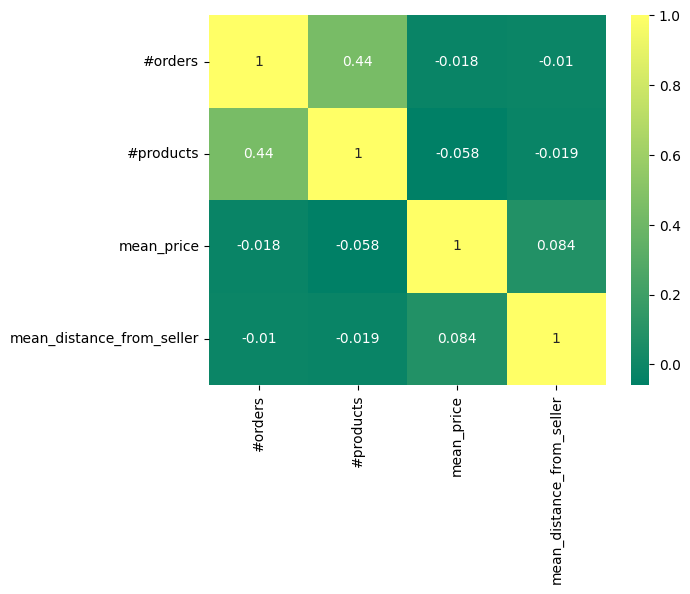

In [17]:
sns.heatmap( result.loc[:,['#orders' , '#products' , 'mean_price' ,'mean_distance_from_seller'] ].corr() , cmap='summer', annot=True )

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('kmean', KMeans(n_clusters=2, init='k-means++', n_init='auto', max_iter=500, tol=0.0001))
    ]
)

In [ ]:
pipe.fit(result.loc[:,['#orders' , '#products' , 'mean_price' ,'mean_distance_from_seller'] ])

In [19]:
pipe[1].inertia_

NameError: name 'pipe' is not defined

In [20]:
wcss = np.ones(25)
for i in range(1,25): # 1 to 14
    pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('kmean', KMeans(n_clusters= i, init='k-means++', n_init='auto', max_iter=500, tol=0.0001))
    ]
        )
    pipe.fit(result.loc[:,['#orders' , '#products' , 'mean_price' ,'mean_distance_from_seller'] ])
    wcss[i] = pipe[1].inertia_

NameError: name 'Pipeline' is not defined

<Axes: >

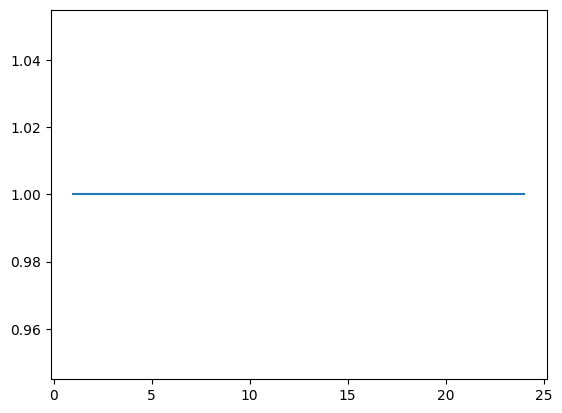

In [21]:
x= np.arange(25 )
sns.lineplot( x=x[1:] , y=wcss[1:] )

In [22]:
    pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('kmean', KMeans(n_clusters= 7 , init='k-means++', n_init='auto', max_iter=500, tol=0.0001))
    ]
    )
    pipe.fit(result.loc[:,['#orders' , '#products' , 'mean_price' ,'mean_distance_from_seller'] ])

NameError: name 'Pipeline' is not defined

In [23]:
pipe[0].mean_

NameError: name 'pipe' is not defined

In [24]:
pipe[1].labels_

NameError: name 'pipe' is not defined

In [23]:
result['label'] = pipe[1].labels_

In [24]:
result.head(4)

,customer_unique_id,#orders,#products,mean_price,mean_lat,mean_lng,mean_distance_from_seller,label
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,-23.340235,-46.830140,110.568636,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,-23.559115,-46.787626,22.168333,5
2,0000f46a3911fa3c0805444483337064,1,1,69.00,-27.542880,-48.633426,516.938836,5
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,-1.312214,-48.483159,2481.287188,1


In [25]:
df = result.groupby('label').agg({'customer_unique_id': 'count',
                             'mean_distance_from_seller': ['mean', 'min' , 'max' , 'std'],
                             'mean_price': ['mean' , 'min' , 'max' ,'std' ] ,
                             '#orders' : 'mean',
                             '#products':'mean',
                            })

df.to_excel('output6.xlsx', index=True)  # Set index=False if you don't want to save the row index

## market basket.

In [40]:
customer_data = pd.merge(olist_orders_dataset, olist_customers_dataset, on = 'customer_id', how = 'inner' )
zip_location =  olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean' , 'geolocation_lng':'mean'}).reset_index().rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix'})
customer_data = pd.merge(  customer_data , zip_location , on='customer_zip_code_prefix', how='inner' ).rename(columns={ 'geolocation_lat':'geolocation_lat_customer' ,'geolocation_lng':'geolocation_lng_customer'}) ## zip location
customer_data = pd.merge(  customer_data,olist_order_items_dataset,on='order_id' , how='inner' ) ## item info
customer_data = pd.merge(  customer_data,olist_sellers_dataset,on='seller_id' , how='inner'  ) ## seller info
customer_data = pd.merge(  customer_data,zip_location.rename(columns={'customer_zip_code_prefix' : 'seller_zip_code_prefix'}),on='seller_zip_code_prefix' , how='inner'  ).rename(columns={ 'geolocation_lat':'geolocation_lat_seller' ,'geolocation_lng':'geolocation_lng_seller'}) ## zip locationv
customer_data.info()

basket_data = pd.merge(customer_data,product_data ,on='product_id',how='inner')
basket_data = pd.merge( basket_data, eng_cat , on = 'product_category_name' , how='inner' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111204 entries, 0 to 111203
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111204 non-null  object        
 1   customer_id                    111204 non-null  object        
 2   order_status                   111204 non-null  object        
 3   order_purchase_timestamp       111204 non-null  datetime64[ns]
 4   order_approved_at              111189 non-null  object        
 5   order_delivered_carrier_date   110509 non-null  object        
 6   order_delivered_customer_date  109336 non-null  object        
 7   order_estimated_delivery_date  111204 non-null  object        
 8   customer_unique_id             111204 non-null  object        
 9   customer_zip_code_prefix       111204 non-null  int64         
 10  customer_city                  111204 non-null  object        
 11  

In [41]:
basket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109602 entries, 0 to 109601
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109602 non-null  object        
 1   customer_id                    109602 non-null  object        
 2   order_status                   109602 non-null  object        
 3   order_purchase_timestamp       109602 non-null  datetime64[ns]
 4   order_approved_at              109588 non-null  object        
 5   order_delivered_carrier_date   108932 non-null  object        
 6   order_delivered_customer_date  107785 non-null  object        
 7   order_estimated_delivery_date  109602 non-null  object        
 8   customer_unique_id             109602 non-null  object        
 9   customer_zip_code_prefix       109602 non-null  int64         
 10  customer_city                  109602 non-null  object        
 11  

In [42]:
basket_data['product_category_name']  = basket_data['product_category_name_english']

In [43]:
basket_data = basket_data[['order_id' , 'customer_id', 'product_id', 'product_category_name' ,  'order_item_id' ]]

In [44]:
basket_data.duplicated().sum()

0

In [45]:
basket_data[ basket_data['customer_id'] =='b331b74b18dc79bcdf6532d51e1637c1' ]

,order_id,customer_id,product_id,product_category_name,order_item_id
109599,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,1
109600,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,2


In [46]:
basket_data.groupby(['order_id', 'product_category_name'])['order_item_id'].count().reset_index()

,order_id,product_category_name,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,1
1,00018f77f2f0320c557190d7a144bdd3,pet_shop,1
2,000229ec398224ef6ca0657da4fc703e,furniture_decor,1
3,00024acbcdf0a6daa1e931b038114c75,perfumery,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,garden_tools,1
...,...,...,...
96763,fffc94f6ce00a00581880bf54a75a037,housewares,1
96764,fffcd46ef2263f404302a634eb57f7eb,computers_accessories,1
96765,fffce4705a9662cd70adb13d4a31832d,sports_leisure,1
96766,fffe18544ffabc95dfada21779c9644f,computers_accessories,1


In [47]:
some = basket_data.groupby(['order_id']).agg( {
    'product_category_name': list
} ).reset_index()
some['product_category_name'] = some['product_category_name'].tolist()
some['product_category_name_'] = some['product_category_name'].apply(set)
some['product_category_name'] = some['product_category_name_'].apply(list)
some['len'] = some['product_category_name'].apply(len)

In [48]:
some[ some['len'] > 2 ]

,order_id,product_category_name,product_category_name_,len
10909,1d23106803c48c391366ff224513fb7f,"[bed_bath_table, furniture_decor, baby]","{bed_bath_table, furniture_decor, baby}",3
11894,1fcbc88015c88c1a14d4b8ec35ea8ed7,"[furniture_decor, pet_shop, sports_leisure]","{furniture_decor, pet_shop, sports_leisure}",3
17727,2f8f31eb2f7b6572836d662a6625c8e4,"[auto, fashion_bags_accessories, musical_instr...","{auto, fashion_bags_accessories, musical_instr...",3
17981,3040863957c9336e7389512584639bb5,"[furniture_decor, watches_gifts, housewares]","{furniture_decor, watches_gifts, housewares}",3
18047,306b4ec62d908535f2bfa2877665e899,"[perfumery, bed_bath_table, market_place]","{perfumery, bed_bath_table, market_place}",3
37022,62ce4e3989a3477928510bb4d1064cc4,"[furniture_decor, home_construction, housewares]","{furniture_decor, home_construction, housewares}",3
44480,76c4c846aae2dae9e87dfa492c3f5259,"[bed_bath_table, garden_tools, construction_to...","{bed_bath_table, garden_tools, construction_to...",3
52359,8c2b13adf3f377c8f2b06b04321b0925,"[bed_bath_table, baby, cool_stuff]","{bed_bath_table, baby, cool_stuff}",3
54352,91be51c856a90d7efe86cf9d082d6ae3,"[cine_photo, telephony, cool_stuff]","{cine_photo, telephony, cool_stuff}",3
63356,a98012aa8c697f2bcff9f8c2183e0f2b,"[computers_accessories, home_construction, coo...","{computers_accessories, home_construction, coo...",3


In [49]:
some['len'].value_counts()

len
1    95313
2      705
3       15
Name: count, dtype: int64

In [50]:
some[ some['len'] > 2 ]

,order_id,product_category_name,product_category_name_,len
10909,1d23106803c48c391366ff224513fb7f,"[bed_bath_table, furniture_decor, baby]","{bed_bath_table, furniture_decor, baby}",3
11894,1fcbc88015c88c1a14d4b8ec35ea8ed7,"[furniture_decor, pet_shop, sports_leisure]","{furniture_decor, pet_shop, sports_leisure}",3
17727,2f8f31eb2f7b6572836d662a6625c8e4,"[auto, fashion_bags_accessories, musical_instr...","{auto, fashion_bags_accessories, musical_instr...",3
17981,3040863957c9336e7389512584639bb5,"[furniture_decor, watches_gifts, housewares]","{furniture_decor, watches_gifts, housewares}",3
18047,306b4ec62d908535f2bfa2877665e899,"[perfumery, bed_bath_table, market_place]","{perfumery, bed_bath_table, market_place}",3
37022,62ce4e3989a3477928510bb4d1064cc4,"[furniture_decor, home_construction, housewares]","{furniture_decor, home_construction, housewares}",3
44480,76c4c846aae2dae9e87dfa492c3f5259,"[bed_bath_table, garden_tools, construction_to...","{bed_bath_table, garden_tools, construction_to...",3
52359,8c2b13adf3f377c8f2b06b04321b0925,"[bed_bath_table, baby, cool_stuff]","{bed_bath_table, baby, cool_stuff}",3
54352,91be51c856a90d7efe86cf9d082d6ae3,"[cine_photo, telephony, cool_stuff]","{cine_photo, telephony, cool_stuff}",3
63356,a98012aa8c697f2bcff9f8c2183e0f2b,"[computers_accessories, home_construction, coo...","{computers_accessories, home_construction, coo...",3


In [54]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


# Assuming 'some' is your DataFrame
categories = some[some['len'] > 1]['product_category_name'].tolist()


# Convert all items to strings, handle NaNs or None
categories = [[ str(item) for item in transaction if item is not None] for transaction in categories ]


# Use TransactionEncoder
te = TransactionEncoder()
combination_bool = te.fit_transform(categories)
dataset = pd.DataFrame(combination_bool, columns=te.columns_)


# print(dataset)

In [55]:
dataset

,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,perfumery,pet_shop,signaling_and_security,small_appliances,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
716,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
717,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
718,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [56]:
frequent_itemsets = apriori( dataset, min_support=0.001, use_colnames=True )
rules = association_rules( frequent_itemsets )

In [57]:
frequent_itemsets.sort_values( 'support' , ascending=False )

,support,itemsets
32,0.277778,(furniture_decor)
6,0.272222,(bed_bath_table)
40,0.141667,(housewares)
5,0.127778,(baby)
34,0.100000,(garden_tools)
...,...,...
202,0.001389,"(electronics, housewares)"
203,0.001389,"(luggage_accessories, electronics)"
106,0.001389,"(bed_bath_table, computers_accessories)"
205,0.001389,"(small_appliances, electronics)"


In [61]:
rules[['antecedents','consequents','antecedent support' ,'consequent support','support','confidence' , 'lift']].head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(art),(furniture_decor),0.008333,0.277778,0.006944,0.833333,3.000000
1,(audio),(watches_gifts),0.008333,0.054167,0.008333,1.000000,18.461538
2,(christmas_supplies),(auto),0.001389,0.048611,0.001389,1.000000,20.571429
3,(fashion_shoes),(baby),0.002778,0.127778,0.002778,1.000000,7.826087
4,(signaling_and_security),(baby),0.001389,0.127778,0.001389,1.000000,7.826087
5,(home_appliances_2),(bed_bath_table),0.001389,0.272222,0.001389,1.000000,3.673469


In [64]:
rules.sort_values( ["support", "confidence","lift"],axis = 0, ascending = False ).sort_index()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(art),(furniture_decor),0.008333,0.277778,0.006944,0.833333,3.000000,0.004630,4.333333,0.672269
1,(audio),(watches_gifts),0.008333,0.054167,0.008333,1.000000,18.461538,0.007882,inf,0.953782
2,(christmas_supplies),(auto),0.001389,0.048611,0.001389,1.000000,20.571429,0.001321,inf,0.952712
3,(fashion_shoes),(baby),0.002778,0.127778,0.002778,1.000000,7.826087,0.002423,inf,0.874652
4,(signaling_and_security),(baby),0.001389,0.127778,0.001389,1.000000,7.826087,0.001211,inf,0.873435
5,(home_appliances_2),(bed_bath_table),0.001389,0.272222,0.001389,1.000000,3.673469,0.001011,inf,0.728790
6,(home_confort),(bed_bath_table),0.069444,0.272222,0.059722,0.860000,3.159184,0.040818,5.198413,0.734467
7,(party_supplies),(bed_bath_table),0.001389,0.272222,0.001389,1.000000,3.673469,0.001011,inf,0.728790
8,(computers),(furniture_decor),0.001389,0.277778,0.001389,1.000000,3.600000,0.001003,inf,0.723227
9,(fashio_female_clothing),(fashion_sport),0.001389,0.002778,0.001389,1.000000,360.000000,0.001385,inf,0.998609


### RFM

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


In [4]:
olist_customers_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
olist_orders_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
olist_order_items_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
olist_geolocation_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
olist_products_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
product_category_name_translation=  pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
olist_geolocation_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
olist_sellers_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
olist_order_payments_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
product_data = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
eng_cat = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
olist_order_payments_dataset = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
filter1 = olist_orders_dataset['order_purchase_timestamp'] > '2016-12-31'
filter2 = olist_orders_dataset['order_purchase_timestamp'] < '2018-09-1'
filter3 = ~olist_orders_dataset['order_status'].isin(['unavailable' ,'canceled']) ## not in condition
olist_orders_dataset = olist_orders_dataset[(filter1 & filter2 & filter3)] ### order between 2017 and 2018 and ordered.
print('numbers of orders : ', olist_orders_dataset.shape[0])
print('first order : '  , olist_orders_dataset['order_purchase_timestamp'].min())
print('last order : ' , olist_orders_dataset['order_purchase_timestamp'].max())

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv'

In [4]:
olist_orders_dataset.info() ## info about the full order( carring couples of items in it.

<class 'pandas.core.frame.DataFrame'>
Index: 97910 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97910 non-null  object        
 1   customer_id                    97910 non-null  object        
 2   order_status                   97910 non-null  object        
 3   order_purchase_timestamp       97910 non-null  datetime64[ns]
 4   order_approved_at              97891 non-null  object        
 5   order_delivered_carrier_date   97306 non-null  object        
 6   order_delivered_customer_date  96203 non-null  object        
 7   order_estimated_delivery_date  97910 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.7+ MB


In [5]:
olist_customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [7]:
olist_customers_dataset.groupby('customer_unique_id').agg({'customer_id':'count'}).head(2)

,customer_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [5]:
customer_data = pd.merge(olist_orders_dataset, olist_customers_dataset, on = 'customer_id', how = 'inner' )
# zip_location =  olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean' , 'geolocation_lng':'mean'}).reset_index().rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix'})
# customer_data = pd.merge(  customer_data , zip_location , on='customer_zip_code_prefix', how='inner' ).rename(columns={ 'geolocation_lat':'geolocation_lat_customer' ,'geolocation_lng':'geolocation_lng_customer'}) ## zip location
customer_data = pd.merge(  customer_data,olist_order_items_dataset,on='order_id' , how='inner' ) ## item info
# customer_data = pd.merge(  customer_data,olist_sellers_dataset,on='seller_id' , how='inner'  ) ## seller info
# customer_data = pd.merge(  customer_data,zip_location.rename(columns={'customer_zip_code_prefix' : 'seller_zip_code_prefix'}),on='seller_zip_code_prefix' , how='inner'  ).rename(columns={ 'geolocation_lat':'geolocation_lat_seller' ,'geolocation_lng':'geolocation_lng_seller'}) ## zip locationv
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111752 entries, 0 to 111751
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111752 non-null  object        
 1   customer_id                    111752 non-null  object        
 2   order_status                   111752 non-null  object        
 3   order_purchase_timestamp       111752 non-null  datetime64[ns]
 4   order_approved_at              111737 non-null  object        
 5   order_delivered_carrier_date   111052 non-null  object        
 6   order_delivered_customer_date  109872 non-null  object        
 7   order_estimated_delivery_date  111752 non-null  object        
 8   customer_unique_id             111752 non-null  object        
 9   customer_zip_code_prefix       111752 non-null  int64         
 10  customer_city                  111752 non-null  object        
 11  

#### Useful columns

In [6]:
rfm_data = customer_data[['order_id' , 'customer_id', 'customer_unique_id', 'order_purchase_timestamp' ,'price' , 'freight_value' ,'order_item_id' ,'product_id' ]]

In [7]:
rfm_data.duplicated().sum()

0

In [8]:
rfm_data[ rfm_data['order_item_id'] > 5 ]

,order_id,customer_id,customer_unique_id,order_purchase_timestamp,price,freight_value,order_item_id,product_id
177,90349f264a3d6a2525a34598d09dda6b,d19f254a07da73a055409256e9bfe40a,831a032a3327e2b8325faf9d37953870,2018-05-11 16:35:19,45.00,7.39,6,216bb0e0cd43ffd832e0973d35e0377e
525,8adafb3466daa5395694d3a906ff9d40,b7919647bde69acc948baa47823d6c75,6ad46014a4203440c38e3dbf7aedf51c,2017-01-25 15:47:27,28.00,8.34,6,871cfa7d587b8305a5a0e376866323ef
600,0f8532e6a9c1e86b215fda5c13f37fad,48c83ab1910a8d95f8702dde180d658b,33d5f77e44abcb42cdfc86854e5fce8c,2017-05-08 14:59:40,112.99,17.53,6,22594ba8fd9a72ad95d352929c821560
810,d5211af24819d319c02a285e7bb51750,a6d8c2fa92836346256c28d885d9eea0,a5931be4783e1a1dfbda5c6e145d96bb,2018-08-03 16:29:05,22.90,6.74,6,7486542600afc050d20740e976ff87f8
3488,28cf49bbfe2683759d3cf866b7fda22f,94a265c7d6fa0389f4fec04d4eae8b66,eb17a45cc9586bc95b8ea855d83e7b6f,2018-01-20 15:47:45,10.00,15.10,6,825993135690981b6014a46dbe75707e
...,...,...,...,...,...,...,...,...
111602,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,6,36f60d45225e60c7da4558b070ce4b60
111603,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,7,36f60d45225e60c7da4558b070ce4b60
111604,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,8,36f60d45225e60c7da4558b070ce4b60
111605,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,9,36f60d45225e60c7da4558b070ce4b60


In [9]:
rfm_data[ rfm_data['order_id'] == 'a483ffe0ce133740ab12ebcba8a3ccf9']

,order_id,customer_id,customer_unique_id,order_purchase_timestamp,price,freight_value,order_item_id,product_id
111597,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,1,36f60d45225e60c7da4558b070ce4b60
111598,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,2,36f60d45225e60c7da4558b070ce4b60
111599,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,3,36f60d45225e60c7da4558b070ce4b60
111600,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,4,36f60d45225e60c7da4558b070ce4b60
111601,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,5,36f60d45225e60c7da4558b070ce4b60
111602,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,6,36f60d45225e60c7da4558b070ce4b60
111603,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,7,36f60d45225e60c7da4558b070ce4b60
111604,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,8,36f60d45225e60c7da4558b070ce4b60
111605,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,9,36f60d45225e60c7da4558b070ce4b60
111606,a483ffe0ce133740ab12ebcba8a3ccf9,e2f063c52fa92b54f186c62b90699c10,09e9991c50513a303a2da26619870d7f,2018-01-10 14:16:10,109.89,13.11,10,36f60d45225e60c7da4558b070ce4b60


* **for each customer last time they visit is recency.**
* **for each customer how frequent they buy is frequency.**
* **for each customer how much he/she spent in one order only.**

##### Aggregating on order because same order_id for each order item in the dataset.

In [10]:
rfm_data.groupby('order_id').agg({ 'customer_unique_id' : 'first' , 'order_purchase_timestamp' : 'first','price':'sum', 'order_item_id' : 'count'  })

,customer_unique_id,order_purchase_timestamp,price,order_item_id
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90,1
00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90,1
000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00,1
00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99,1
00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90,1
...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,0c9aeda10a71f369396d0c04dce13a64,2018-04-23 13:57:06,299.99,1
fffcd46ef2263f404302a634eb57f7eb,0da9fe112eae0c74d3ba1fe16de0988b,2018-07-14 10:26:46,350.00,1
fffce4705a9662cd70adb13d4a31832d,cd79b407828f02fdbba457111c38e4c4,2017-10-23 17:07:56,99.90,1


In [11]:
# rfm_data = rfm_data.groupby('order_id').agg({
#     'customer_unique_id': 'first',
#     'order_purchase_timestamp': 'first',
#     'price': 'sum',
#     'order_item_id': 'count'
# })
rfm_data = rfm_data.rename(columns={'order_item_id':'product_counts'} )

In [12]:
rfm_data

,order_id,customer_id,customer_unique_id,order_purchase_timestamp,price,freight_value,product_counts,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99,8.72,1,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70,22.76,1,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90,19.22,1,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,45.00,27.20,1,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,19.90,8.72,1,65266b2da20d04dbe00c5c2d3bb7859e
...,...,...,...,...,...,...,...,...
111747,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,174.90,20.10,1,f1d4ce8c6dd66c47bbaa8c6781c2a923
111748,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,205.99,65.02,1,b80910977a37536adeddd63663f916ad
111749,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,179.99,40.59,1,d1c427060a0f73f6b889a5c7c61f2ac4
111750,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,179.99,40.59,2,d1c427060a0f73f6b889a5c7c61f2ac4


In [13]:
rfm_data[ rfm_data.order_id == '76931aa364051d5d57f6a23aa352956a' ]

,order_id,customer_id,customer_unique_id,order_purchase_timestamp,price,freight_value,product_counts,product_id
111638,76931aa364051d5d57f6a23aa352956a,b477202dca6a3ad89828fdd5748dc849,dc9ccd8be2d922f8583d97933b06c5f4,2017-11-18 12:51:32,75.9,9.35,1,af16005fca813272caf59c432153949e
111639,76931aa364051d5d57f6a23aa352956a,b477202dca6a3ad89828fdd5748dc849,dc9ccd8be2d922f8583d97933b06c5f4,2017-11-18 12:51:32,75.9,9.35,2,af16005fca813272caf59c432153949e
111640,76931aa364051d5d57f6a23aa352956a,b477202dca6a3ad89828fdd5748dc849,dc9ccd8be2d922f8583d97933b06c5f4,2017-11-18 12:51:32,75.9,9.35,3,af16005fca813272caf59c432153949e
111641,76931aa364051d5d57f6a23aa352956a,b477202dca6a3ad89828fdd5748dc849,dc9ccd8be2d922f8583d97933b06c5f4,2017-11-18 12:51:32,75.9,9.35,4,af16005fca813272caf59c432153949e


In [14]:
rfm_data['order_purchase_timestamp'] = pd.to_datetime(rfm_data['order_purchase_timestamp'])

In [15]:
rfm_data.head(3)

,order_id,customer_id,customer_unique_id,order_purchase_timestamp,price,freight_value,product_counts,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99,8.72,1,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70,22.76,1,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90,19.22,1,aa4383b373c6aca5d8797843e5594415


In [16]:
rfm_data.groupby('customer_unique_id').agg({'order_id':'count'})['order_id'].value_counts()

order_id
1     82941
2      8922
3      1661
4       624
5       245
6       193
7        46
8        16
11       11
9        11
10       11
12        9
14        3
15        2
13        2
20        2
16        1
18        1
21        1
24        1
Name: count, dtype: int64

In [17]:
day= '2018-09-01 00:00:00'
date = pd.to_datetime(day)
date2 = pd.to_datetime('2019-09-01 00:00:00')
print(date2-date)

import warnings
warnings.filterwarnings('ignore')

365 days 00:00:00


#### Aggregation Data on customer data we have 
* **count : frequency**
* **max : recent visit of customer**
* **sum : monetry**

In [18]:
rfm_dataset = rfm_data.groupby('customer_unique_id').agg({'order_id':'count' , 'order_purchase_timestamp' : 'max', 'price' : 'sum' }).reset_index()
# rough = aggregated_df.groupby('customer_unique_id').agg({
#     'order_id': lambda x: x.nunique(),  # count unique order IDs
#     'order_purchase_timestamp': lambda x: x.max(),  # get the latest timestamp
#     'price': lambda x: x.sum()  # sum of prices
# })

In [19]:
rfm_dataset['order_id'].value_counts()

order_id
1     82941
2      8922
3      1661
4       624
5       245
6       193
7        46
8        16
11       11
9        11
10       11
12        9
14        3
15        2
13        2
20        2
16        1
18        1
21        1
24        1
Name: count, dtype: int64

In [21]:
rfm_dataset[ rfm_dataset['order_id'] > 2 ]

,customer_unique_id,order_id,order_purchase_timestamp,price
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,180.00
...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2,2017-06-08 21:00:36,1570.00
94699,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,64.89
94700,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,89.90
94701,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,115.00


In [22]:
rfm_dataset

,customer_unique_id,order_id,order_purchase_timestamp,price
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,180.00
...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2,2017-06-08 21:00:36,1570.00
94699,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,64.89
94700,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,89.90
94701,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,115.00


In [23]:
rfm_dataset['order_purchase_timestamp'] = rfm_dataset['order_purchase_timestamp'].apply(lambda x : (date - x).days )

In [24]:
rfm_dataset.rename(columns={'order_id': 'frequency' , 'order_purchase_timestamp':'recency' , 'price':'monetry' } , inplace=True )

In [26]:
rfm_dataset [rfm_dataset['frequency'] > 2 ]

,customer_unique_id,frequency,recency,monetry
22,000fbf0473c10fc1ab6f8d2d286ce20c,4,36,285.80
156,0064a1b5f5cddd047c987b988a90c8c1,4,182,215.60
200,0085139b503668b3addcfe826d91be8d,3,213,465.88
223,0096c18412349537abc45e350581cbbc,4,535,679.60
228,0097fca0db567f5ca79509b7b4fc1c2d,7,134,172.14
...,...,...,...,...
94574,ff9ff869636c26565ded16038be5fa7d,3,468,269.70
94606,ffbb6557e45f7158781514f0efddb0d5,4,280,91.60
94667,ffe780a8995715d9560ca10f3351710f,3,386,89.70
94686,fff22793223fe80c97a8fd02ac5c6295,3,66,66.00


In [26]:
rfm_dataset.head()

,customer_unique_id,frequency,recency,monetry
0,0000366f3b9a7992bf8c76cfdf3221e2,1,113,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,116,18.90
2,0000f46a3911fa3c0805444483337064,1,539,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,323,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,290,180.00


In [27]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(rfm_dataset[['frequency','recency','monetry']])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


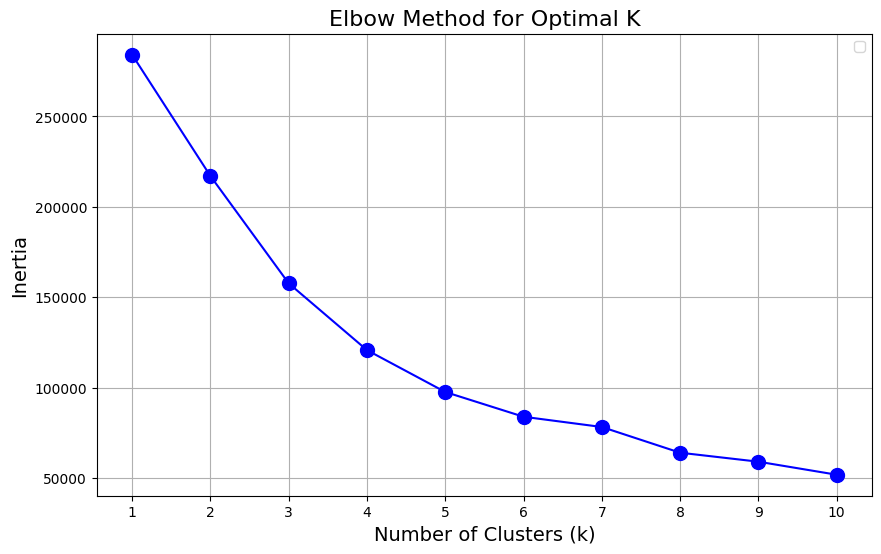

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming `scaled` is your scaled dataset

# Calculate inertia for different numbers of clusters
inertia = []
for i in np.arange(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 11), inertia, marker="o", linestyle='-', color='b', markersize=10)
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(np.arange(1, 11))
plt.grid(True)
# plt.axvline(x=4, color='r', linestyle='--', label='Optimal k')
plt.legend()
plt.show()

In [29]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
rfm_dataset["Clusters"]=(kmeans.labels_+1)

In [30]:
rfm_dataset

,customer_unique_id,frequency,recency,monetry,Clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1,113,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,116,18.90,1
2,0000f46a3911fa3c0805444483337064,1,539,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,323,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,1,290,180.00,2
...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2,449,1570.00,3
94699,fffea47cd6d3cc0a88bd621562a9d061,1,264,64.89,2
94700,ffff371b4d645b6ecea244b27531430a,1,570,89.90,2
94701,ffff5962728ec6157033ef9805bacc48,1,121,115.00,1


In [34]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

kmeans=KMeans(n_clusters=4)
kmeans.fit(scaled)
rfm_dataset["Clusters"]=(kmeans.labels_+1)

agg_functions = {
    'frequency': ['mean'],
    'recency': 'mean',
    'monetry': 'mean',
    'customer_unique_id':'count'
}

results = rfm_dataset.groupby('Clusters').agg(agg_functions)


# Flatten the MultiIndex columns
results.columns = ['_'.join(col).strip() for col in results.columns.values]

results.rename(columns={'customer_unique_id_count':'customers_in_clusters',"frequency_mean":'frequency'} , inplace=True)

In [36]:
results

,frequency,recency_mean,monetry_mean,customers_in_clusters
Clusters,,,,
1,1.097325,129.559804,113.522607,51518
2,1.095859,387.002327,113.683288,38254
3,1.190542,238.181734,1148.554474,2157
4,3.868421,230.945205,279.307678,2774


6 clusters

Explanation of Labels
Frequent Moderates (Cluster 1):

Higher frequency and moderate recency and monetary values.
These customers purchase often but with moderate spending.
Infrequent Low Spenders (Cluster 2):

Lowest frequency and moderate recency.
These customers purchase infrequently and spend less.
Infrequent High Spenders (Cluster 3):

Lower frequency but very high monetary value.
These customers purchase infrequently but spend a lot when they do.
Rare Low Spenders (Cluster 4):

Low frequency, high recency (long time since last purchase), and low spending.
These customers rarely purchase and spend little.
Frequent High Spenders (Cluster 5):

Highest frequency and high monetary value.
These are the best customers who purchase frequently and spend a lot.
New Customers (Cluster 6):

Low frequency but very recent purchases.
These are likely new customers who have just started purchasing.

##### RFM Segmentation
* **Segment 1 : Occasionally purchase(only once)**
* **relatievly recent purchase**
* **relatevely less monetry**
* **carries largest group of customer.**

* **Segment 2 :Again Occasionally purchase(only once)**
* **Purchase long time ago.**
* **Their average spending is similar to Cluster 1.**
* **2nd largest group.**

* **These customers also purchase occasionally (about once).**
* **They made their last purchase a long time ago.**
* **Their average spending is similar to Cluster 1.**
* **This cluster is relatively large.**

In [140]:
g = sns.FacetGrid(tips, col="Clusters")
g.map(sns.scatterplot, "total_bill", "tip")

NameError: name 'tips' is not defined

In [33]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
rfm_dataset["Clusters"]=(kmeans.labels_+1)

agg_functions = {
    'frequency': ['mean'],
    'recency': 'mean',
    'monetry': 'mean',
    'customer_unique_id':'count'
}

results = rfm_dataset.groupby('Clusters').agg(agg_functions)

# Flatten the MultiIndex columns
results.columns = ['_'.join(col).strip() for col in results.columns.values]

results.rename(columns={'customer_unique_id_count':'customers_in_clusters',"frequency_mean":'frequency'} , inplace=True)

In [34]:
results

,frequency,recency_mean,monetry_mean,customers_in_clusters
Clusters,,,,
1,1.091840,387.417670,116.594135,38382
2,1.091359,129.389875,115.508678,51555
3,2.849350,229.309484,633.521544,4766


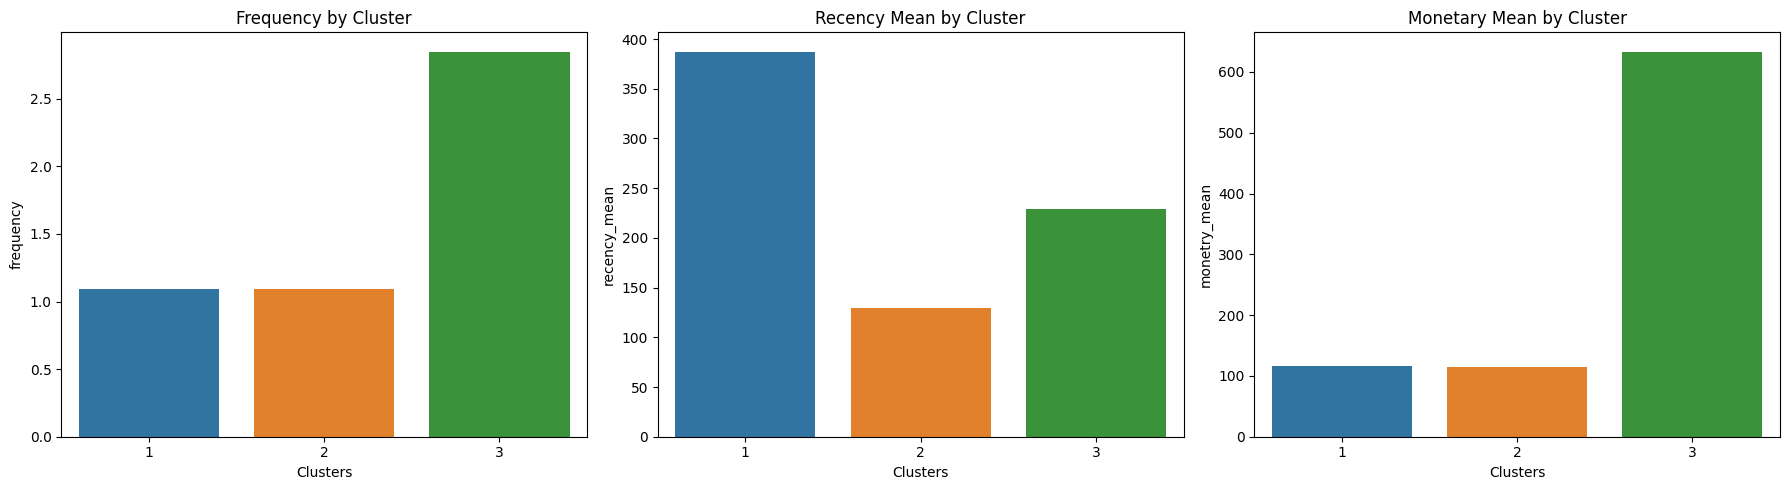

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = results.reset_index()
# Ploatting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='Clusters', y='frequency', data=df, ax=axes[0])
axes[0].set_title('Frequency by Cluster')


sns.barplot(x='Clusters', y='recency_mean', data=df, ax=axes[1])
axes[1].set_title('Recency Mean by Cluster')


sns.barplot(x='Clusters', y='monetry_mean', data=df, ax=axes[2])
axes[2].set_title('Monetary Mean by Cluster')


plt.tight_layout()
plt.show()

In [55]:
rfm_dataset

,customer_unique_id,frequency,recency,monetry,Clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1,113,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,116,18.90,1
2,0000f46a3911fa3c0805444483337064,1,539,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,323,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,1,290,180.00,2
...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2,449,1570.00,3
94699,fffea47cd6d3cc0a88bd621562a9d061,1,264,64.89,2
94700,ffff371b4d645b6ecea244b27531430a,1,570,89.90,2
94701,ffff5962728ec6157033ef9805bacc48,1,121,115.00,1


<Axes: xlabel='recency', ylabel='Count'>

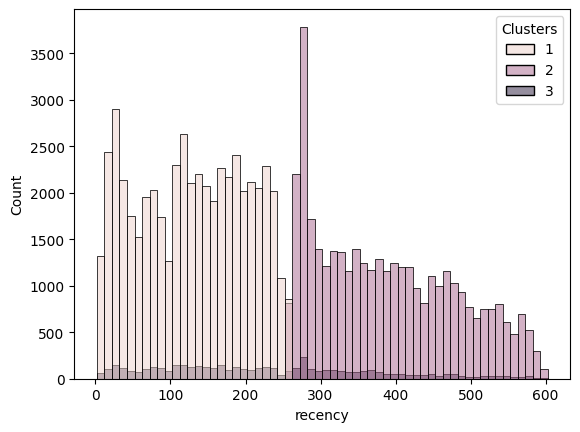

In [57]:
sns.histplot(data=rfm_dataset, x="recency", hue="Clusters")

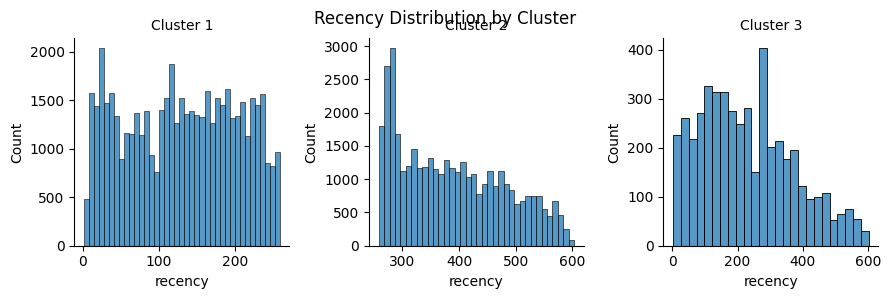

In [58]:
# Set up the FacetGrid
g = sns.FacetGrid(rfm_dataset, col="Clusters", col_wrap=3, sharex=False, sharey=False)

# Map the histplot to each facet
g.map(sns.histplot, "recency")

# Add titles and adjust layout
g.set_titles(col_template="Cluster {col_name}")
# plt.subplots_adjust(top=2)
g.fig.suptitle('Recency Distribution by Cluster')
plt.show()

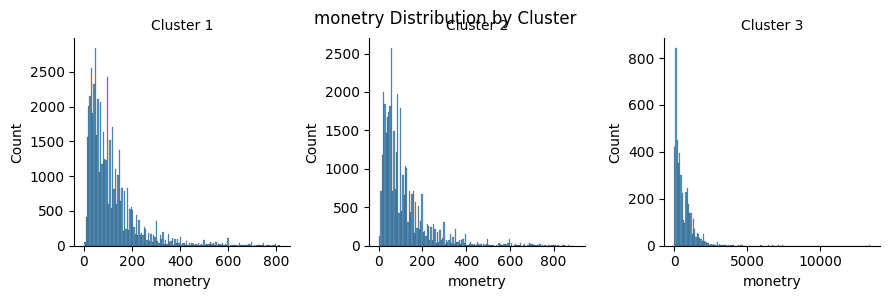

In [59]:
# Set up the FacetGrid
g = sns.FacetGrid(rfm_dataset, col="Clusters", col_wrap=3, sharex=False, sharey=False)

# Map the histplot to each facet
g.map(sns.histplot, "monetry")

# Add titles and adjust layout
g.set_titles(col_template="Cluster {col_name}")
# plt.subplots_adjust(top=2)
g.fig.suptitle('monetry Distribution by Cluster')
plt.show()

<Axes: xlabel='Clusters', ylabel='count'>

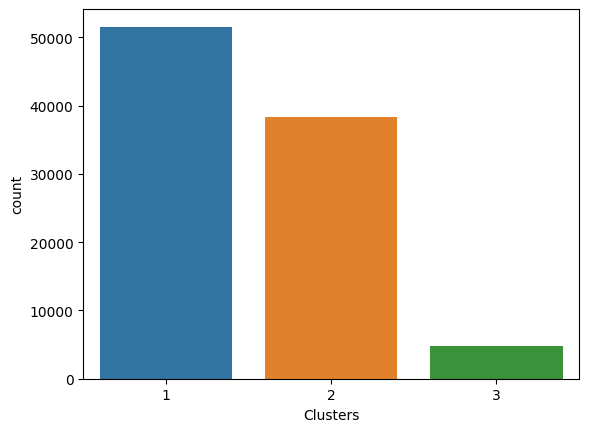

In [60]:
sns.countplot(rfm_dataset, x="Clusters")

In [61]:
rfm_dataset

,customer_unique_id,frequency,recency,monetry,Clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1,113,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,116,18.90,1
2,0000f46a3911fa3c0805444483337064,1,539,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,323,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,1,290,180.00,2
...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2,449,1570.00,3
94699,fffea47cd6d3cc0a88bd621562a9d061,1,264,64.89,2
94700,ffff371b4d645b6ecea244b27531430a,1,570,89.90,2
94701,ffff5962728ec6157033ef9805bacc48,1,121,115.00,1


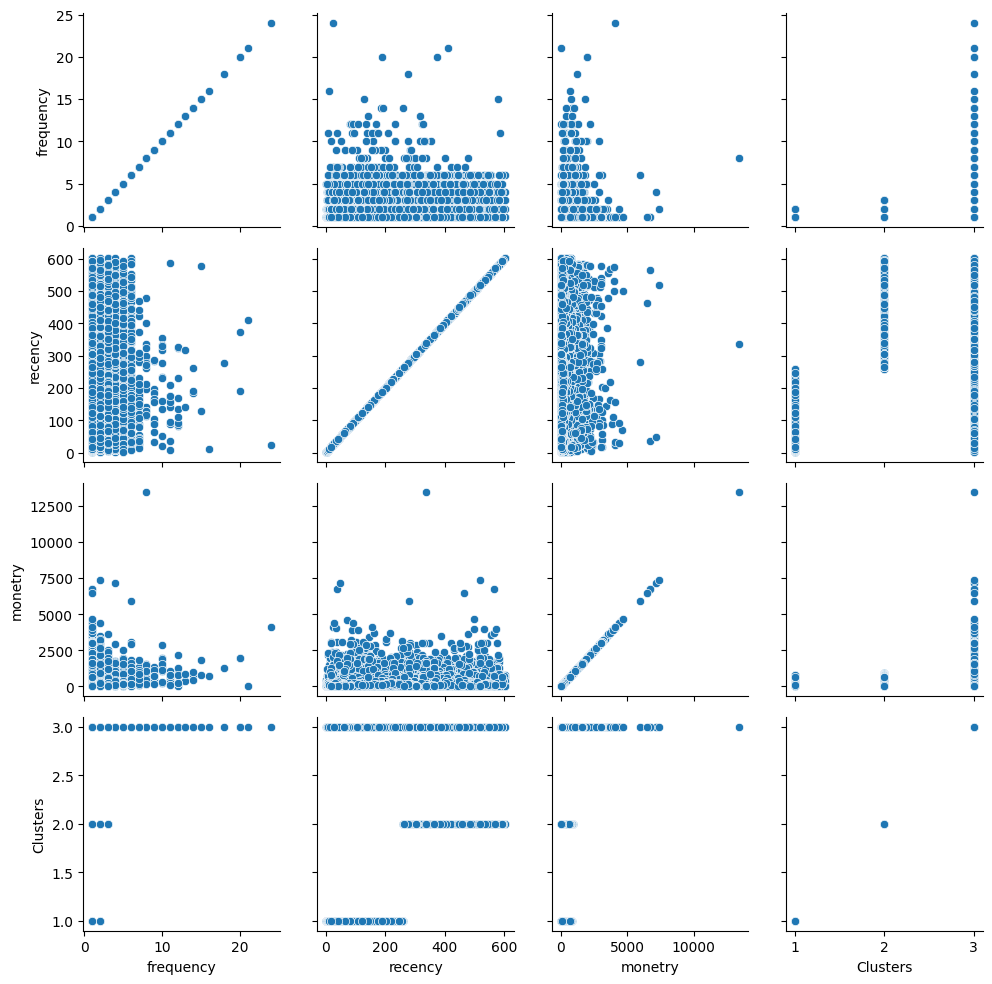

In [71]:
g = sns.PairGrid(rfm_dataset)
g.map(sns.scatterplot)

In [ ]:
rfm_dataset

* **higher frequency people have lower recency.**